# Visualise experimental data

The data is collected though several runs in the notebook *hierarcical-cnn-visualisation-coco.ipynb*
and *hierarcical-cnn-visualisation.ipynb*

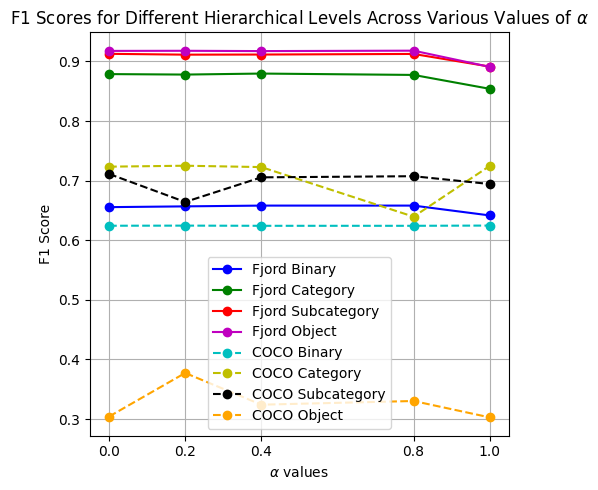

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data provided earlier, with the specific naming convention for COCO
alpha_values = [0, 0.2, 0.4, 0.8, 1]
fjord_data = {
    'Binary': [0.6555, 0.6568, 0.6581, 0.6581, 0.6416],
    'Category': [0.8787, 0.8779, 0.8796, 0.8773, 0.8540],
    'Subcategory': [0.9127, 0.9113, 0.9115, 0.9125, 0.8913],
    'Object': [0.9176, 0.9178, 0.9173, 0.9180, 0.8908]
}
coco_data = {
    'Binary': [0.6243, 0.6245, 0.6242, 0.6242, 0.6246],
    'Category': [0.7234, 0.725, 0.7227, 0.6395, 0.7246],
    'Subcategory': [0.7112, 0.6642, 0.7055, 0.7074, 0.6943],
    'Object': [0.3042, 0.3773, 0.3241, 0.3303, 0.3028]
}

# Define a color palette for the plot
palette = {
    'Binary': 'b', 'Category': 'g', 'Subcategory': 'r', 'Object': 'm',
    'COCO_Binary': 'c', 'COCO_Category': 'y', 'COCO_Subcategory': 'k', 'COCO_Object': 'orange'
}

# Initialize the plot
plt.figure(figsize=(5, 5))

# Plot Fjord data
for level, scores in fjord_data.items():
    plt.plot(alpha_values, scores, marker='o', color=palette[level], label=f'Fjord {level}')

# Plot COCO data with dashed lines
for level, scores in coco_data.items():
    plt.plot(alpha_values, scores, '--o', color=palette[f'COCO_{level}'], label=f'COCO {level.replace(" ", " ")}')

# Title and labels
plt.title('F1 Scores for Different Hierarchical Levels Across Various Values of $\\alpha$')
plt.xlabel('$\\alpha$ values')
plt.ylabel('F1 Score')
plt.xticks(alpha_values)  # Ensure only the defined alpha values are used as x-ticks

# Add a legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('F1_Scores_Visualization.svg', format='svg')  # Saving as SVG
plt.show()


# Visualisation of Yolo v8 performance on COCO vs Fjord

In [2]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import ast

df = pd.read_csv("model_metrics.csv")
df['F1-Confidence Curve Values'] = df['F1-Confidence Curve Values'].apply(ast.literal_eval)

if df.empty:
    # Initialize a list to store dictionaries of data
    data = []

    # Model configurations and their respective sizes
    models = [
        ("runs/segment/Yolov8n-seg-finetune/weights/best.pt", "n", "Fjord"),
        ("runs/segment/Yolov8s-seg-finetune/weights/best.pt", "s", "Fjord"),
        ("runs/segment/Yolov8m-seg-finetune/weights/best.pt", "m", "Fjord"),
        ("runs/segment/Yolov8l-seg-finetune/weights/best.pt", "l", "Fjord"),
        ("runs/segment/Yolov8x-seg-finetune/weights/best.pt", "x", "Fjord"),
        ("yolov8n-seg.pt", "n", "COCO"),
        ("yolov8s-seg.pt", "s", "COCO"),
        ("yolov8m-seg.pt", "m", "COCO"),
        ("yolov8l-seg.pt", "l", "COCO"),
        ("yolov8x-seg.pt", "x", "COCO")
    ]

    # Iterate over each model configuration
    for config, size, dataset in models:
        # Load the model
        model = YOLO(config);

        # Calculate the total number of parameters
        total_params = sum(p.numel() for p in model.parameters());

        # Evaluate the model to get metrics
        metrics = model.val();

        # Calculate mAP50-95
        mAP5095 = metrics.results_dict.get('metrics/mAP50-95(M)', None);

        # Retrieve F1-Confidence Curve values
        f1_scores = metrics.curves_results[metrics.curves.index('F1-Confidence(M)')][1].mean(axis=0).tolist()

        # Create a dictionary of the data
        model_data = {
            'Model': size,
            'Dataset': dataset,
            'Parameters': total_params,
            'mAP50-95': mAP5095,
            'F1-Confidence Curve Values': f1_scores
        }

        # Append the dictionary to the data list
        data.append(model_data)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)
    df.to_csv('model_metrics.csv', index=False)

# F1-Confidence

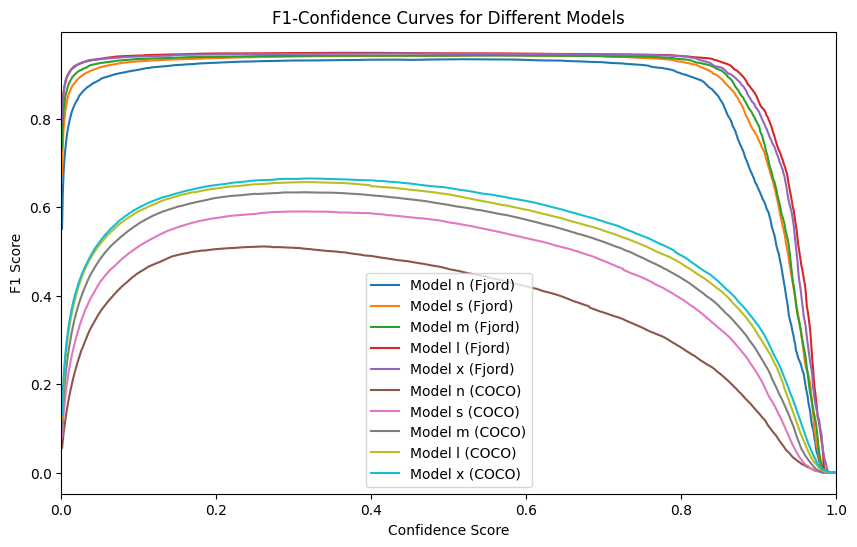

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import ast


# Initialize the plot
plt.figure(figsize=(10, 6))

# Generate 1000 points evenly spaced between 0 and 1 for the x-axis (confidence scores)
confidence_scores = np.linspace(0, 1, len(df['F1-Confidence Curve Values'][0]))

# Iterate over the rows in the DataFrame and plot each F1-Confidence curve
for index, row in df.iterrows():
    plt.plot(confidence_scores, row['F1-Confidence Curve Values'], label=f"Model {row['Model']} ({row['Dataset']})")

# Setting the x-axis range from 0 to 1
plt.xlim(0, 1)

# Adding labels and title
plt.xlabel('Confidence Score')
plt.ylabel('F1 Score')
plt.title('F1-Confidence Curves for Different Models')

# Adding a legend to distinguish between different models
plt.legend()

# Save the plot as an SVG file
plt.savefig('f1_confidence_curves.svg', format='svg')

# Parameters vs mAP

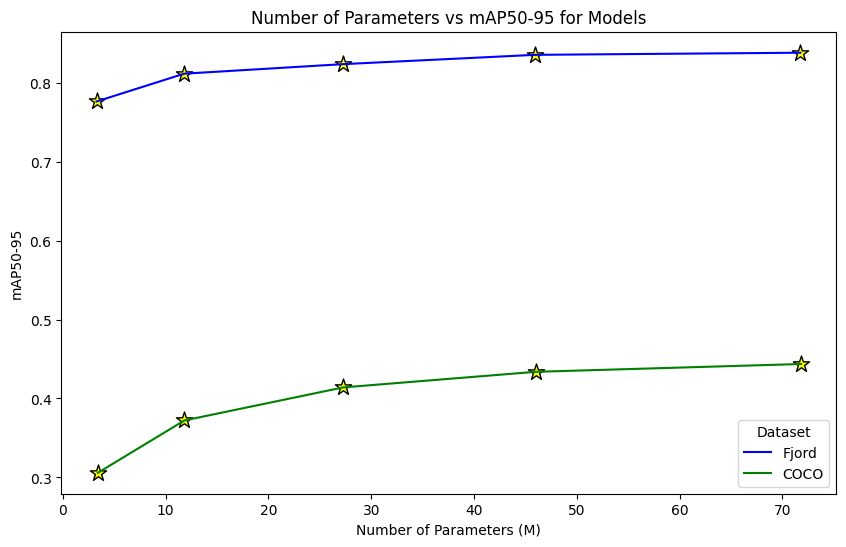

In [10]:
import matplotlib.pyplot as plt

# Initialize the plot
plt.figure(figsize=(10, 6))

# Convert parameters to millions for easier readability directly in the dataframe
df['Parameters (M)'] = df['Parameters'] / 1e6

# Get unique datasets
datasets = df['Dataset'].unique()

# Define some colors for the datasets
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Add more colors if you have more datasets

# Iterate through each dataset and plot its data points and lines
for dataset, color in zip(datasets, colors):
    df_filtered = df[df['Dataset'] == dataset].sort_values('Parameters')
    plt.plot(df_filtered['Parameters (M)'], df_filtered['mAP50-95'], linestyle='-', color=color, label=dataset)
    # Add yellow stars with dark outlines for each point, make them larger
    plt.scatter(df_filtered['Parameters (M)'], df_filtered['mAP50-95'], marker='*', color='yellow', edgecolors='black', s=150)

# Adding labels, title, and legend
plt.xlabel('Number of Parameters (M)')
plt.ylabel('mAP50-95')
plt.title('Number of Parameters vs mAP50-95 for Models')
plt.legend(title='Dataset')

# Save the plot as an SVG file
plt.savefig('parameters_vs_map.svg', format='svg')

# Displaying the plot
plt.show()